In [128]:
import torch
import time
import torch.nn as nn
from datasets import load_dataset, concatenate_datasets
from transformers import DistilBertTokenizer, DistilBertModel

In [ ]:
dataset = load_dataset("imdb")

In [ ]:
def make_balanced_sample_dataset(num_per_class):
    def sample_class(split, label, n):
        # Filter for the given label
        ds = dataset[split].filter(lambda x: x['label'] == label)
        # Shuffle and select n samples
        ds = ds.shuffle().select(range(n))
        return ds

    # Train
    train_pos = sample_class('train', label=1, n=num_per_class)
    train_neg = sample_class('train', label=0, n=num_per_class)
    small_train_dataset = concatenate_datasets([train_pos, train_neg]).shuffle(seed=42)

    # Test
    test_pos = sample_class('test', label=1, n=num_per_class)
    test_neg = sample_class('test', label=0, n=num_per_class)
    small_test_dataset = concatenate_datasets([test_pos, test_neg]).shuffle(seed=42)

    return small_train_dataset, small_test_dataset

sample_train, sample_test = make_balanced_sample_dataset(250)
print(len(sample_train), len(sample_test))

In [166]:
# Load dataset and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)

def encode(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=256)

start_train = time.time()
encoded_train = sample_train.map(encode, batched=True)
encoded_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
print(f"Time taken to encode training set: {time.time() - start_train:.2f} seconds")

start_test = time.time()
encoded_test = sample_test.map(encode, batched=True)
encoded_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
print(f"Time taken to encode test set: {time.time() - start_test:.2f} seconds")

Map: 100%|██████████| 500/500 [00:01<00:00, 258.53 examples/s]


Time taken to encode training set: 2.41 seconds


Map: 100%|██████████| 500/500 [00:02<00:00, 191.11 examples/s]

Time taken to encode test set: 2.97 seconds


In [167]:
def embed_batch(batch):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    return {'embeddings': outputs.last_hidden_state.cpu()}

start_train = time.time()
embedding_train = encoded_train.map(embed_batch, batched=True, batch_size=32)
print(f"Time taken to embed training set: {time.time() - start_train:.2f} seconds")
start_test = time.time()
embedding_test = encoded_test.map(embed_batch, batched=True, batch_size=32)
print(f"Time taken to embed test set: {time.time() - start_test:.2f} seconds")

Map: 100%|██████████| 500/500 [00:08<00:00, 56.65 examples/s]


Time taken to embed training set: 21.19 seconds


Map: 100%|██████████| 500/500 [00:08<00:00, 59.19 examples/s]

Time taken to embed test set: 18.92 seconds


In [168]:
def collate_embeddings(batch):
    embeddings = torch.stack([b['embeddings'] for b in batch])
    mask = torch.stack([b['attention_mask'] for b in batch]).bool()
    labels = torch.tensor([b['label'] for b in batch])
    return embeddings, mask, labels

train_loader = torch.utils.data.DataLoader(embedding_train, batch_size=32, shuffle=True, collate_fn=collate_embeddings)
test_loader = torch.utils.data.DataLoader(embedding_test, batch_size=32, collate_fn=collate_embeddings)

In [169]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int):
        super().__init__()

        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.mha = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            batch_first=True
        )

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, X: torch.Tensor, mask: torch.Tensor = None):
        if mask is not None:
            key_padding_mask = (mask == 0)
            key_padding_mask = key_padding_mask.bool()
        else:
            key_padding_mask = None

        mha_out, _ = self.mha(X, X, X, key_padding_mask=key_padding_mask)
        X1 = self.ln1(X + mha_out)

        ff_out = self.ff(X1)
        out = self.ln2(X1 + ff_out)
        return out


class Encoder(nn.Module):
    def __init__(self, num_layers: int, d_model: int, n_heads: int, d_ff: int, max_len: int):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderBlock(
                    d_model,
                    n_heads,
                    d_ff,
                )
            for _ in range(num_layers)
        ])

    def forward(self, X: torch.Tensor, mask: torch.Tensor):
        for layer in self.layers:
            X = layer(X, mask=mask)
        return X


class Classifier(nn.Module):
    def __init__(self, d_model: int, num_classes: int):
        super().__init__()
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, enc_out: torch.Tensor, mask: torch.Tensor):
        mask = mask.unsqueeze(-1).float()
        masked = enc_out * mask

        sum_vec = masked.sum(dim=1)
        count = mask.sum(dim=1).clamp_min(1.0)

        pooled = sum_vec / count
        return self.fc(pooled)


class TransformerClassifier(nn.Module):
    def __init__(self, num_layers: int, d_model: int, n_heads: int, d_ff: int, max_len: int, num_classes: int):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, n_heads, d_ff, max_len)
        self.classifier = Classifier(d_model, num_classes)

    def forward(self, X: torch.Tensor, mask: torch.Tensor):
        enc_out = self.encoder(X, mask)
        logits = self.classifier(enc_out, mask)
        return logits

In [170]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerClassifier(
    num_layers= 2,
    d_model=    768,
    n_heads=    4,
    d_ff=       64,
    max_len=    2500,
    num_classes=2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)

def train(model, loader):
    model.train()
    total_loss = 0
    for embeddings, mask, labels in loader:
        embeddings = embeddings.to(device)
        mask = mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(embeddings, mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, mask, labels in loader:
            embeddings = embeddings.to(device)
            mask = mask.to(device)
            labels = labels.to(device)

            logits = model(embeddings, mask)
            pred = logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [171]:
print("PyTorch Transformer Classifier module loaded.")
epochs = 10
losses = []
accs = []

for epoch in range(epochs):
    start_epoch = time.time()
    loss = train(model, train_loader)
    acc = evaluate(model, test_loader)
    losses.append(loss)
    accs.append(acc)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Acc: {acc:.4f} - Time: {time.time() - start_epoch:.2f} sec")

PyTorch Transformer Classifier module loaded.
Epoch 1/10 - Loss: 0.7190 - Acc: 0.5040 - Time: 8.34 sec
Epoch 2/10 - Loss: 0.6759 - Acc: 0.6600 - Time: 6.92 sec
Epoch 3/10 - Loss: 0.6309 - Acc: 0.6660 - Time: 6.72 sec
Epoch 4/10 - Loss: 0.5849 - Acc: 0.7800 - Time: 5.70 sec
Epoch 5/10 - Loss: 0.5366 - Acc: 0.7900 - Time: 6.71 sec
Epoch 6/10 - Loss: 0.4930 - Acc: 0.8160 - Time: 6.76 sec
Epoch 7/10 - Loss: 0.4536 - Acc: 0.8240 - Time: 6.77 sec
Epoch 8/10 - Loss: 0.4083 - Acc: 0.8100 - Time: 6.61 sec
Epoch 9/10 - Loss: 0.3765 - Acc: 0.8360 - Time: 5.68 sec
Epoch 10/10 - Loss: 0.3353 - Acc: 0.8500 - Time: 6.85 sec


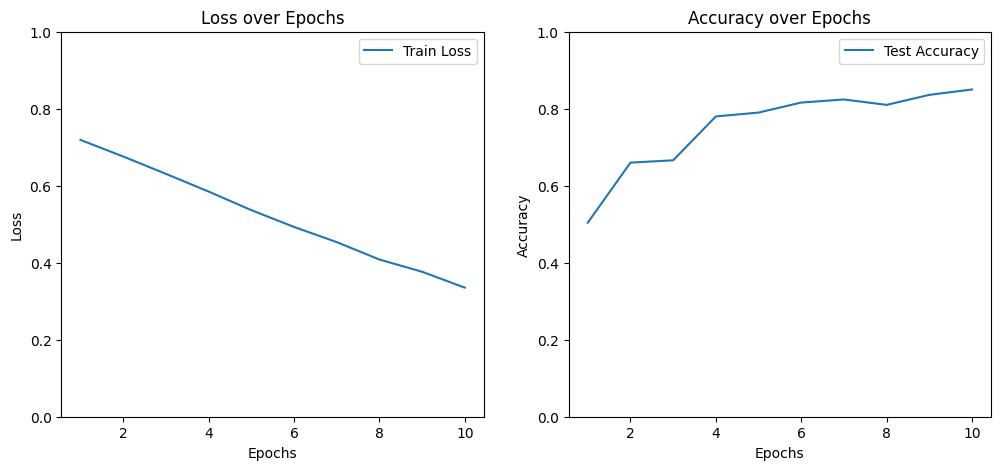

In [172]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()